In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Setup

In [1]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

  Using cached voxelmorph-0.2-py3-none-any.whl.metadata (660 bytes)
  Using cached neurite-0.2-py3-none-any.whl.metadata (653 bytes)
  Using cached pystrum-0.4-py3-none-any.whl
Using cached voxelmorph-0.2-py3-none-any.whl (54 kB)
Using cached neurite-0.2-py3-none-any.whl (108 kB)


In [2]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.model_selection import train_test_split

# Download dataset

In [3]:
# download dataset
filename = 'COMULISSHGBF.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/QQKxdTGoLPmEbc4/download/COMULISSHGBF.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [4]:
def load_data(jsonData, dataFolderPath, filterString='0001'):
    training_paths = []
    for i in range(len(jsonData['training_paired_images'])):
        tmproot, tmpext = os.path.splitext(jsonData['training_paired_images'][i]['moving'])
        root, ext = os.path.splitext(tmproot)
        splitRoot = root.split('_')
        if splitRoot[-1] == filterString:
            training_paths.append(jsonData['training_paired_images'][i])

    fixedData = []
    movingData = []
    for image in training_paths:
        fixedImg = nib.load(dataFolderPath + image['fixed'].removeprefix('.')).get_fdata()
        fixedData.append(fixedImg.astype(np.uint8))
        movingImg = nib.load(dataFolderPath + image['moving'].removeprefix('.')).get_fdata()
        movingImg_reshaped = movingImg.reshape(jsonData['tensorImageShape'][0]['0'][0], jsonData['tensorImageShape'][0]['0'][1], 3)
        movingData.append(movingImg_reshaped.astype(np.uint8))

    return np.array(fixedData), np.array(movingData)

In [5]:
# load data
with open('./COMULISSHGBF/COMULISSHGBF_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './COMULISSHGBF'
data_fixed_raw, data_moved_raw = load_data(data_json, dataFolder)

# Preprocess Data

In [8]:
# filter data since some of the fixed images are nearly empty
means = np.mean(data_fixed_raw, axis=(1,2,3))
mask = means >= 3

data_fixed_filtered = data_fixed_raw[mask]
data_moved_filtered = data_moved_raw[mask]

In [17]:
data_fixed_filtered.shape

(124, 834, 834, 1)

In [13]:
# split dataset
random_state = 10

fixed_train_raw, fixed_test_raw, moved_train_raw, moved_test_raw = train_test_split(data_fixed_filtered, data_moved_filtered, test_size=0.2, random_state=random_state)
fixed_val_raw, fixed_test_raw, moved_val_raw, moved_test_raw = train_test_split(fixed_test_raw, moved_test_raw, test_size=0.5, random_state=random_state)

In [14]:
fixed_train_raw.shape

(99, 834, 834, 1)

In [15]:
fixed_val_raw.shape

(12, 834, 834, 1)

In [16]:
fixed_test_raw.shape

(13, 834, 834, 1)

(-0.5, 833.5, 833.5, -0.5)

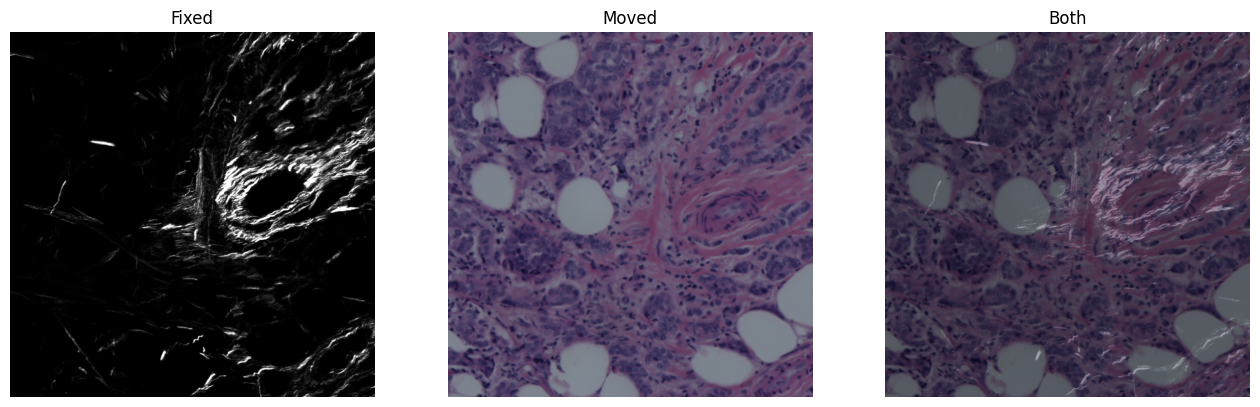

In [29]:
# preview data
img = 1

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(fixed_train_raw[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(moved_train_raw[img])
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(fixed_train_raw[img],cmap='gray')
ax2.imshow(moved_train_raw[img], alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

In [18]:
def transform_data(fixed, moved, target_size=(512,512)):
  # Resize images
  data_fixed_resized = []
  for sample in fixed:
      data_fixed_resized.append(cv2.resize(sample,target_size))
  data_fixed_resized = np.array(data_fixed_resized)

  data_moved_resized = []
  for sample in moved:
      data_moved_resized.append(cv2.resize(sample,target_size))
  data_moved_resized = np.array(data_moved_resized)

  # Get moved images as grayscales
  data_moved_gray = np.zeros_like(data_fixed_resized)
  for idx, val in enumerate(data_moved_resized):
      data_moved_gray[idx] = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)

  # get edges of fixed images
  data_fixed_edges = np.zeros_like(data_fixed_resized)
  for idx, val in enumerate(data_fixed_resized):
      canny = cv2.Canny(val,50,50)
      data_fixed_edges[idx] = cv2.dilate(canny, np.ones((3, 3), np.uint8), iterations=2)

  # get edges of moved images
  data_moved_edges = np.zeros_like(data_moved_gray)
  for idx, val in enumerate(data_moved_gray):
      canny = 255 - cv2.Canny(val,50,100)
      data_moved_edges[idx] = cv2.erode(canny, np.ones((5, 5), np.uint8), iterations=1)

  # Normalize images
  return data_fixed_edges / np.max(data_fixed_edges), data_moved_edges / np.max(data_moved_edges)

In [22]:
fixed_train, moved_train = transform_data(fixed_train_raw, moved_train_raw)
fixed_val, moved_val = transform_data(fixed_val_raw, moved_val_raw)
fixed_test, moved_test = transform_data(fixed_test_raw, moved_test_raw)

(-0.5, 511.5, 511.5, -0.5)

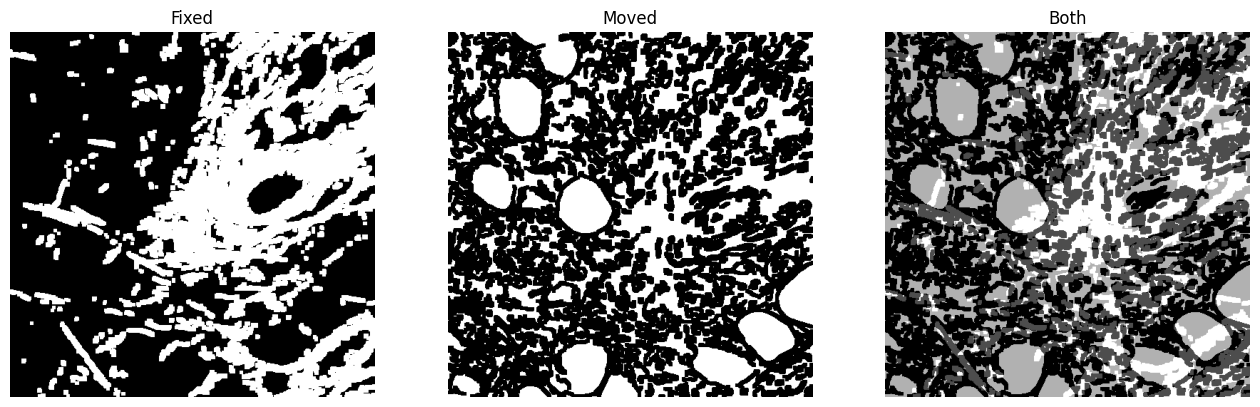

In [31]:
# view preprocessed data
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(fixed_train[img],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(moved_train[img], cmap='gray')
ax1.set_title("Moved")
ax1.axis("off")
ax2.imshow(fixed_train[img],cmap='gray')
ax2.imshow(moved_train[img], cmap='gray', alpha=0.7)
ax2.set_title("Both")
ax2.axis("off")

# Define Model

In [32]:
# Define the input shapes
inshape = fixed_test.shape[1:3]
nb_features = [
    [32, 64, 128, 256],  # encoder-channels
    [256, 128, 64, 32, 32]  # eecoder-channels
]

# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 512, 512, 1), (None, 512, 512, 1)
output shape: (None, 512, 512, 1), (None, 512, 512, 2)


In [33]:
# define loss functions
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# balance the two losses with hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [34]:
# compile model
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train model

In [35]:
# define a data generator that adds augmentation
def vxm_data_generator(fixed, moved, batch_size=32, augmentation=True):
    vol_shape = fixed.shape[1:3]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx = np.random.randint(0, fixed.shape[0], size=batch_size)

        fixed_image = fixed[idx, ..., np.newaxis]
        moving_image = moved[idx, ..., np.newaxis]

        if augmentation:
          if np.random.randint(0,2) == 0:
            fixed_image = np.flip(fixed_image,1)
            moving_image = np.flip(moving_image,1)

          for _ in range(np.random.randint(0,4)):
            fixed_image = np.rot90(fixed_image,axes=(1,2))
            moving_image = np.rot90(moving_image,axes=(1,2))

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

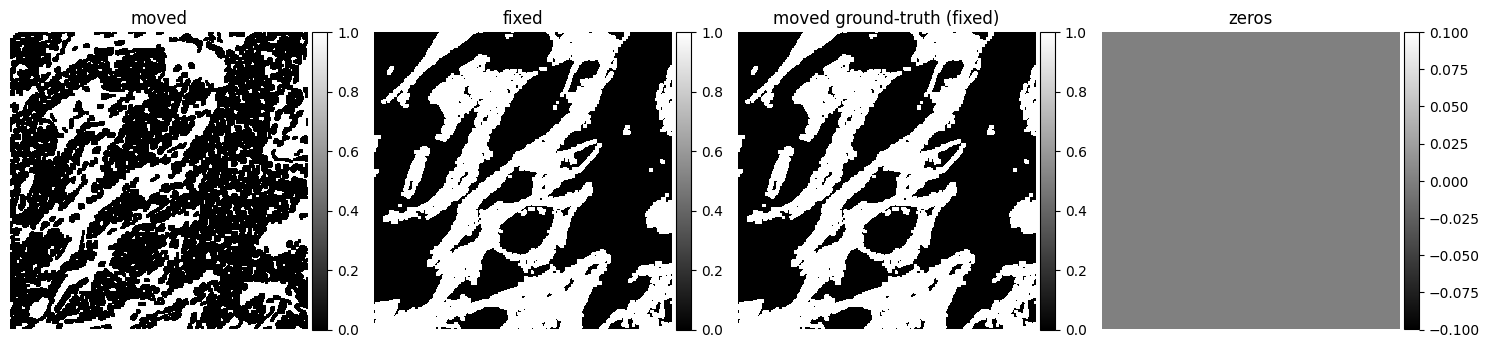

In [36]:
batch_size = 16

# define training generator
train_generator = vxm_data_generator(fixed_train, moved_train, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# view generated data
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moved', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [37]:
# define  validation generator
val_generator = vxm_data_generator(fixed_val, moved_val, batch_size=batch_size//4)

In [155]:
# train model
nb_epochs = 30
steps_per_epoch = 20
validation_steps = 2
hist = vxm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2
)

Epoch 1/30
20/20 - 20s - loss: 0.4378 - vxm_dense_transformer_loss: 0.4342 - vxm_dense_flow_loss: 0.0738 - val_loss: 0.4705 - val_vxm_dense_transformer_loss: 0.4573 - val_vxm_dense_flow_loss: 0.2640 - 20s/epoch - 1s/step
Epoch 2/30
20/20 - 14s - loss: 0.3648 - vxm_dense_transformer_loss: 0.3474 - vxm_dense_flow_loss: 0.3471 - val_loss: 0.3398 - val_vxm_dense_transformer_loss: 0.3162 - val_vxm_dense_flow_loss: 0.4715 - 14s/epoch - 678ms/step
Epoch 3/30
20/20 - 14s - loss: 0.2659 - vxm_dense_transformer_loss: 0.2378 - vxm_dense_flow_loss: 0.5614 - val_loss: 0.2971 - val_vxm_dense_transformer_loss: 0.2665 - val_vxm_dense_flow_loss: 0.6112 - 14s/epoch - 676ms/step
Epoch 4/30
20/20 - 13s - loss: 0.2205 - vxm_dense_transformer_loss: 0.1877 - vxm_dense_flow_loss: 0.6578 - val_loss: 0.2088 - val_vxm_dense_transformer_loss: 0.1771 - val_vxm_dense_flow_loss: 0.6343 - 13s/epoch - 673ms/step
Epoch 5/30
20/20 - 13s - loss: 0.2009 - vxm_dense_transformer_loss: 0.1670 - vxm_dense_flow_loss: 0.6781 - 

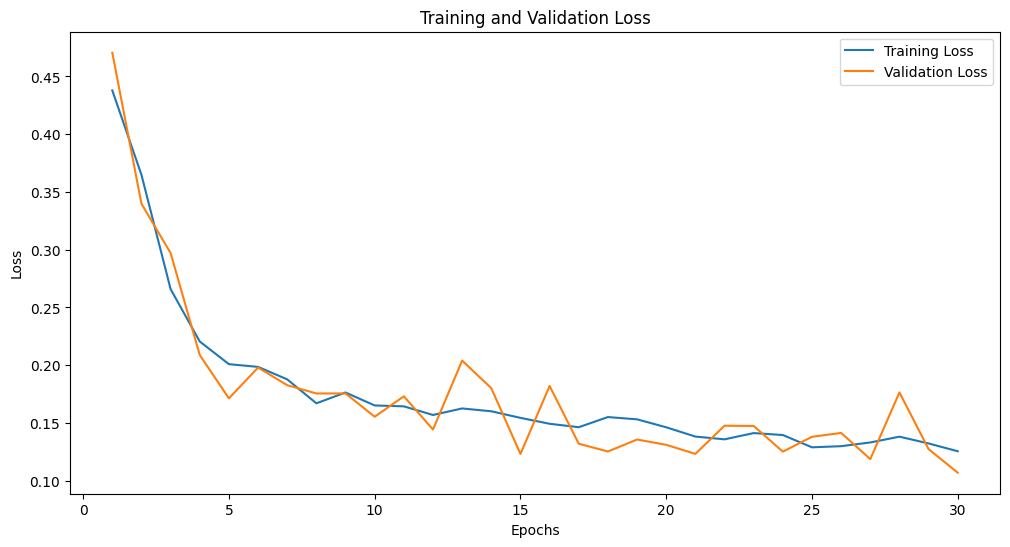

In [156]:
# extract train- and validation-loss
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# plot history
plt.figure(figsize=(12, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, nb_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Test registration

In [157]:
# define validation generator
test_generator = vxm_data_generator(fixed_test, moved_test, batch_size = 1, augmentation=False)
test_input, _ = next(test_generator)

In [158]:
# perform prediction
test_pred = vxm_model.predict(test_input)

1/1 [==============================] - 0s 325ms/step


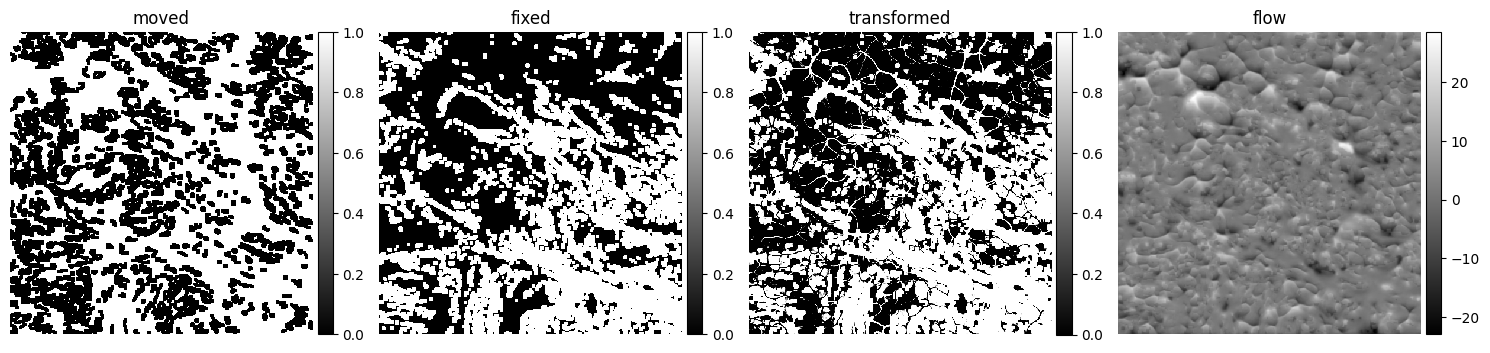

In [159]:
# view result
images = [img[0, :, :, 0] for img in test_input + test_pred]
titles = ['moved', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

(-0.5, 511.5, 511.5, -0.5)

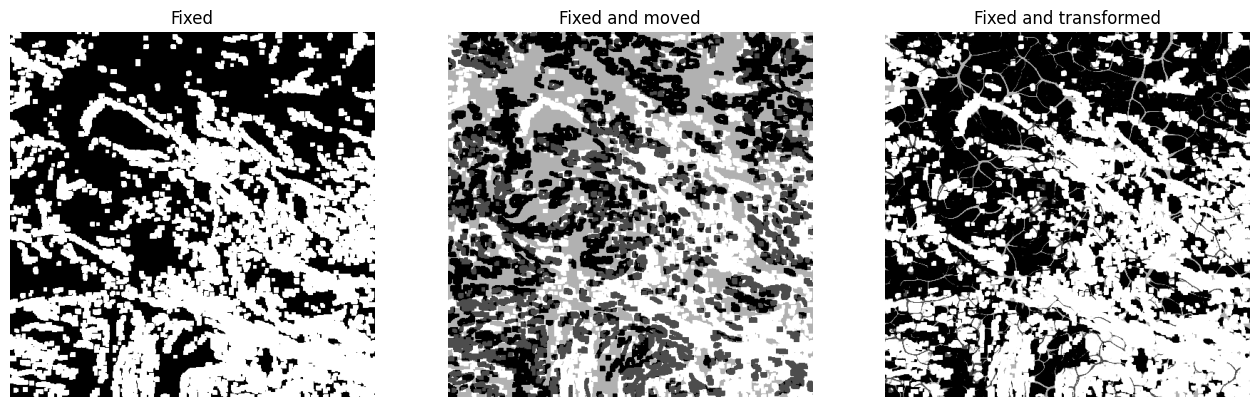

In [160]:
# view results
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(test_input[1][0],cmap='gray')
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(test_input[1][0],cmap='gray')
ax1.imshow(test_input[0][0],cmap='gray', alpha=0.7)
ax1.set_title("Fixed and moved")
ax1.axis("off")
ax2.imshow(test_input[1][0],cmap='gray')
ax2.imshow(test_pred[0][0],cmap='gray', alpha=0.7)
ax2.set_title("Fixed and transformed")
ax2.axis("off")

In [188]:
displacement_field = test_pred[1][0]
input_image = test_input[0][0]
height, width = input_image.shape[:2]
channels = 1

# Apply displacement field to original resized picture using spatial transformer
inputs_image = tf.keras.Input(shape=(height, width, channels))
inputs_disp = tf.keras.Input(shape=(height, width, 2))

spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
moved_image = spatial_transformer([inputs_image, inputs_disp])

# Define model
transformer_model = tf.keras.Model(inputs=[inputs_image, inputs_disp], outputs=moved_image)

# Make prediction
predicted_image = transformer_model.predict([np.expand_dims(input_image, axis=0), np.expand_dims(displacement_field, axis=0)])[0]

1/1 [==============================] - 0s 203ms/step


(-0.5, 511.5, 511.5, -0.5)

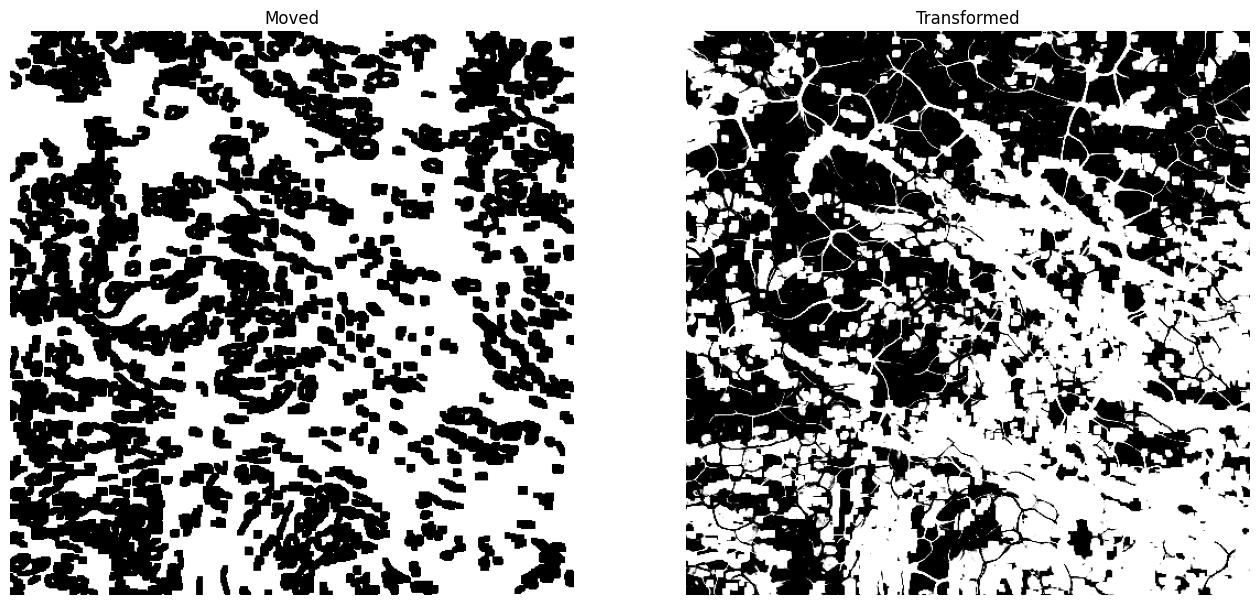

In [189]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,8))
ax0.imshow(input_image,cmap='gray')
ax0.set_title("Moved")
ax0.axis("off")
ax1.imshow(predicted_image,cmap='gray')
ax1.set_title("Transformed")
ax1.axis("off")